<a href="https://colab.research.google.com/github/jtfreitas/NN_DL/blob/main/HW2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q optuna
!wget -O vae_tools.py https://raw.githubusercontent.com/jtfreitas/NN_DL/04c6bddad631521acd7294367fd8b86634a0eeef/HW2/vae_tools.py

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 72.0 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 146 kB 69.9 MB/s 
     |████████████████████████████████| 112 kB 64.2 MB/s 
--2022-06-21 12:09:13--  https://raw.githubusercontent.com/jtfreitas/NN_DL/04c6bddad631521acd7294367fd8b86634a0eeef/HW2/vae_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18174 (18K) [text/plain]
Saving to: ‘vae_tools.py’

vae_tools.py        100%[===================>]  17.75K  --.-KB/s    in 0.001s  

2022-06-21 12:09:13 (25.1 MB/s) - ‘vae_tools.py’ saved 

In [2]:
%load_ext autoreload
%autoreload 2
import random
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import utils as vutils
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg


import vae_tools as vt
seed = 69420
# Check if GPU is available
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device in use: {device}")

random.seed(seed)
torch.manual_seed(seed)
print(f"Random seed: {seed}")

Device in use: cuda
Random seed: 69420


In [3]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



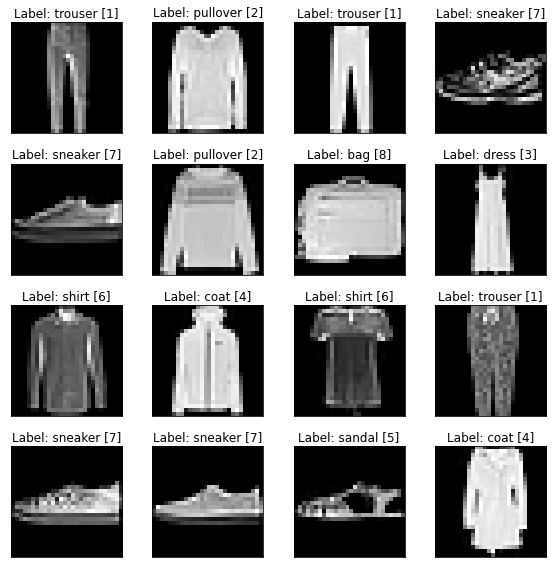

In [4]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(4, 4, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

### Define dataloaders
train_dataloader = DataLoader(train_dataset,
                            batch_size=256, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,
                            batch_size=256, shuffle=False)


HP_search_subset = torch.utils.data.Subset(train_dataset, list(range(0, len(train_dataset)//5 )))
HP_search_dataloader = Dataloader(HP_search_subset,
                                  batch_size = 120, shuffle = True)
# Set the train and test transform
train_dataset.transform = train_transform
test_dataset.transform = test_transform

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [6]:
def AE_objective(trial):
    """
    I perform a Bayesian-like hyperparameter search, using optuna's TPESampler.
    This generally allows a more thorough search compared to completely random
    sampling methods, while saving computation time compared to a complete grid
    search, especially considering the large range of filters considered.
    Overall, it's a good compromise between the certainty of grid-search and
    the efficiency of a random search.

    The best model is chosen based on the test data loss after five epochs.
    """
    params = {
        'conv1': {'filters': trial.suggest_int('filters1', 16, 32),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv2': {'filters': trial.suggest_int('filters2', 64, 128),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv3': {'filters': trial.suggest_int('filters3', 256, 512),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 0},
        'lin1': trial.suggest_int('lin1', 32, 128),
        'latent_space': trial.suggest_int('latent_space', 2, 16)
    }

    model = vt.Autoencoder(28, params, device, keep_loss=False)
    model.to(device)

    lr = trial.suggest_loguniform('lr', 1e-5, 5e-4)
    params_to_optimize = [
        {'params': model.parameters()},
    ]
    optim_type = trial.suggest_categorical(
        'optimizer', ['Adam', 'Adagrad', 'RMSprop'])
    optim = getattr(torch.optim, optim_type)(params_to_optimize, lr=lr)
    loss_fn = torch.nn.MSELoss()
    val_loss = vt.train_AE(
        model, 5, train_dataloader, loss_fn, optim, device, test_dataloader, 5, loss_fn, optim, device,
        verbose=False)[0]

    return val_loss

In [7]:
study = optuna.create_study(direction='minimize') #Goal is to minimize the loss
study.optimize(AE_objective, n_trials = 20) #20 different models are tested

[I 2022-06-21 12:09:59,073] A new study created in memory with name: no-name-a8763efa-8bfb-481b-ac74-c25838ef46c1
[I 2022-06-21 12:10:45,186] Trial 0 finished with value: 0.08598838001489639 and parameters: {'filters1': 32, 'filters2': 70, 'filters3': 284, 'lin1': 88, 'latent_space': 11, 'lr': 0.00012805903916991032, 'optimizer': 'Adagrad'}. Best is trial 0 with value: 0.08598838001489639.


Best loss = 0.0860 in epoch 4


[I 2022-06-21 12:11:20,451] Trial 1 finished with value: 0.13281074166297913 and parameters: {'filters1': 21, 'filters2': 119, 'filters3': 431, 'lin1': 47, 'latent_space': 9, 'lr': 2.1725934052146954e-05, 'optimizer': 'Adagrad'}. Best is trial 0 with value: 0.08598838001489639.


Best loss = 0.1328 in epoch 4


[I 2022-06-21 12:11:55,184] Trial 2 finished with value: 0.04110193997621536 and parameters: {'filters1': 29, 'filters2': 93, 'filters3': 292, 'lin1': 123, 'latent_space': 8, 'lr': 0.0003410385546005553, 'optimizer': 'Adagrad'}. Best is trial 2 with value: 0.04110193997621536.


Best loss = 0.0411 in epoch 4


[I 2022-06-21 12:12:29,507] Trial 3 finished with value: 0.0379781574010849 and parameters: {'filters1': 31, 'filters2': 75, 'filters3': 384, 'lin1': 36, 'latent_space': 2, 'lr': 8.081137517642957e-05, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.0379781574010849.


Best loss = 0.0380 in epoch 4


[I 2022-06-21 12:13:03,712] Trial 4 finished with value: 0.1765272468328476 and parameters: {'filters1': 23, 'filters2': 96, 'filters3': 354, 'lin1': 125, 'latent_space': 5, 'lr': 1.6717025630812193e-05, 'optimizer': 'Adagrad'}. Best is trial 3 with value: 0.0379781574010849.


Best loss = 0.1765 in epoch 4


[I 2022-06-21 12:13:38,406] Trial 5 finished with value: 0.019260818138718605 and parameters: {'filters1': 20, 'filters2': 77, 'filters3': 414, 'lin1': 95, 'latent_space': 14, 'lr': 0.00016217094882727833, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0193 in epoch 4


[I 2022-06-21 12:14:11,698] Trial 6 finished with value: 0.026878254488110542 and parameters: {'filters1': 16, 'filters2': 81, 'filters3': 258, 'lin1': 100, 'latent_space': 10, 'lr': 0.00010111089929290581, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0269 in epoch 4


[I 2022-06-21 12:14:46,695] Trial 7 finished with value: 0.03484679013490677 and parameters: {'filters1': 25, 'filters2': 107, 'filters3': 350, 'lin1': 34, 'latent_space': 2, 'lr': 0.00015949110485949313, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0348 in epoch 4


[I 2022-06-21 12:15:26,315] Trial 8 finished with value: 0.0813654437661171 and parameters: {'filters1': 26, 'filters2': 70, 'filters3': 388, 'lin1': 101, 'latent_space': 3, 'lr': 0.00013515698133134246, 'optimizer': 'Adagrad'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0814 in epoch 4


[I 2022-06-21 12:16:01,683] Trial 9 finished with value: 0.02464820258319378 and parameters: {'filters1': 32, 'filters2': 66, 'filters3': 364, 'lin1': 126, 'latent_space': 7, 'lr': 0.0001266175864382308, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0246 in epoch 4


[I 2022-06-21 12:16:38,403] Trial 10 finished with value: 0.02974548563361168 and parameters: {'filters1': 18, 'filters2': 84, 'filters3': 505, 'lin1': 63, 'latent_space': 16, 'lr': 3.580052711777546e-05, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0297 in epoch 4


[I 2022-06-21 12:17:13,871] Trial 11 finished with value: 0.02021723985671997 and parameters: {'filters1': 21, 'filters2': 64, 'filters3': 466, 'lin1': 108, 'latent_space': 15, 'lr': 0.0003959430682867687, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0202 in epoch 3


[I 2022-06-21 12:17:49,277] Trial 12 finished with value: 0.01935255341231823 and parameters: {'filters1': 20, 'filters2': 85, 'filters3': 476, 'lin1': 103, 'latent_space': 15, 'lr': 0.00048109534381208813, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0194 in epoch 4


[I 2022-06-21 12:18:28,819] Trial 13 finished with value: 0.021377723664045334 and parameters: {'filters1': 19, 'filters2': 88, 'filters3': 440, 'lin1': 77, 'latent_space': 13, 'lr': 0.00028944220439671553, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.019260818138718605.


Best loss = 0.0214 in epoch 4


[I 2022-06-21 12:19:06,231] Trial 14 finished with value: 0.017825938761234283 and parameters: {'filters1': 22, 'filters2': 106, 'filters3': 511, 'lin1': 83, 'latent_space': 13, 'lr': 0.00023046252291486895, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.017825938761234283.


Best loss = 0.0178 in epoch 4


[I 2022-06-21 12:19:42,878] Trial 15 finished with value: 0.023513920605182648 and parameters: {'filters1': 23, 'filters2': 107, 'filters3': 512, 'lin1': 75, 'latent_space': 12, 'lr': 4.942945581640965e-05, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.017825938761234283.


Best loss = 0.0235 in epoch 4


[I 2022-06-21 12:20:17,810] Trial 16 finished with value: 0.017198193818330765 and parameters: {'filters1': 16, 'filters2': 125, 'filters3': 418, 'lin1': 88, 'latent_space': 13, 'lr': 0.00022946258008507402, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.017198193818330765.


Best loss = 0.0172 in epoch 4


[I 2022-06-21 12:20:53,592] Trial 17 finished with value: 0.018578406423330307 and parameters: {'filters1': 16, 'filters2': 128, 'filters3': 483, 'lin1': 61, 'latent_space': 12, 'lr': 0.00022360756160769724, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.017198193818330765.


Best loss = 0.0186 in epoch 4


[I 2022-06-21 12:21:29,419] Trial 18 finished with value: 0.017934387549757957 and parameters: {'filters1': 27, 'filters2': 105, 'filters3': 455, 'lin1': 86, 'latent_space': 13, 'lr': 0.00021550147896113824, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.017198193818330765.


Best loss = 0.0179 in epoch 4


[I 2022-06-21 12:22:04,135] Trial 19 finished with value: 0.02449459582567215 and parameters: {'filters1': 18, 'filters2': 115, 'filters3': 329, 'lin1': 62, 'latent_space': 10, 'lr': 5.887966054986798e-05, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.017198193818330765.


Best loss = 0.0245 in epoch 4


In [9]:
#Grab the best model parameters from the study
best_params = study.best_params

#Format the parameters according to the structure of the autoencoder
best_params = {
    'conv1': {'filters': study.best_params['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': study.best_params['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': study.best_params['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': study.best_params['lin1'],
    'latent_space': study.best_params['latent_space']
}

#Instantiate the autoencoder, set up torch loss and optimizer
best_AE = vt.Autoencoder(28, best_params, device)

loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': best_AE.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=study.best_params['lr'],
                         weight_decay=1e-5)

best_AE.to(device)
loss_fn.to(device)

MSELoss()

In [10]:
no_epochs = 20

vt.train_AE(best_AE, train_dataloader, test_dataloader, 20, loss_fn, optim,
            device = device, save_dir =f'best_AE_z{best_AE.latent_space}')

EPOCH 1/20 : 
partial train loss (single batch): 0.029721partial train loss (single batch): 0.029721	Finding validation loss... Validation loss: 0.028444
EPOCH 2/20 : 
partial train loss (single batch): 0.022540partial train loss (single batch): 0.022540	Finding validation loss... Validation loss: 0.021508
EPOCH 3/20 : 
partial train loss (single batch): 0.018085partial train loss (single batch): 0.018085	Finding validation loss... Validation loss: 0.019928
EPOCH 4/20 : 
partial train loss (single batch): 0.018933partial train loss (single batch): 0.018933	Finding validation loss... Validation loss: 0.018314
EPOCH 5/20 : 
partial train loss (single batch): 0.017255partial train loss (single batch): 0.017255	Finding validation loss... Validation loss: 0.017265
EPOCH 6/20 : 
partial train loss (single batch): 0.016638partial train loss (single batch): 0.016638	Finding validation loss... Validation loss: 0.016475
EPOCH 7/20 : 
partial train loss (single batch): 0.015974partial train loss 

(tensor(0.0126), 19)

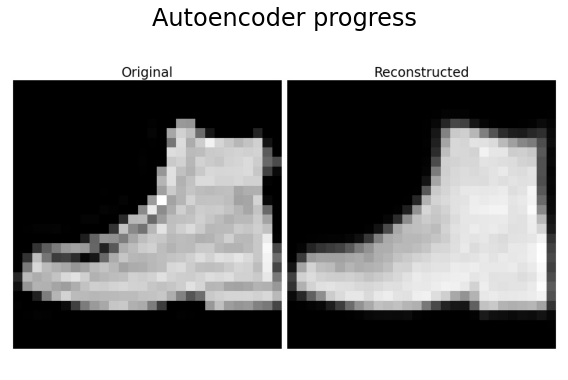

In [25]:
def read_img(i):
    try:
        return mpimg.imread(f'best_AE_z{best_AE.latent_space}/plots/t={i}.jpg')
    except FileNotFoundError:
        return None
fig = plt.figure(figsize=(8,6), tight_layout='pad')
fig.suptitle('Autoencoder progress', fontsize=24)
plt.axis("off")
img_list = [read_img(i) for i in range(1, no_epochs+1)]
ims = [[plt.imshow(i, animated=True)] for i in img_list if type(i) == np.ndarray]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# GAN

In [26]:
def GAN_objective(trial):
    """
    Performs hyperparameter search task identically to AE_objective(trial)
    The best model is chosen based on the test data loss after five epochs.
    """

    params = {
        'latent_space' : trial.suggest_int('latent_space', 10, 500),
        'G_filters' : trial.suggest_int('G_filters', 32, 128),
        'D_filters' : trial.suggest_int('D_filters', 32, 128),
        'n_channels' : 1,
        'opt' : trial.suggest_categorical(
            'optimizer', ['Adam', 'Adagrad', 'RMSprop']),
        'lr' : trial.suggest_loguniform('lr', 1e-5, 5e-4)
    }

    model = vt.GAN(params, device)
    model.to(device)
    params_to_optimize = [
        {'params': model.parameters()},
    ]

    criterion = torch.nn.BCEWithLogitsLoss()
    val_loss = vt.train_GAN(model, train_dataloader, 30,
            criterion,
            device, saturating=False, snapshots = False, save_dir=None, verbose=False):
    

    return val_loss

In [ ]:
gan_study = optuna.create_study(GAN_objective, )

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 100, 'G_filters' : 64, 'D_filters' : 28, 'n_channels' : 1, 'opt' : 'Adam', 'lr' : 1e-5}

gan = vt.GAN(params, device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

gan.to(device)
loss_history, img_list = vt.train_GAN(gan, train_dataloader, 10, criterion, device, saturating=True, snapshots = True)

In [ ]:
gan.zero_grad()
test_data = test_dataset[0][0].unsqueeze(0).to(device)
D_out = gan.netD(test_data)

label = torch.tensor([1],
                dtype=torch.float, device=device).reshape((1,1,1,1))
    

criterion(D_out, label)

In [ ]:
rand_noise = torch.randn(64, gan.latent_space, 1, 1, device=device)

gen_fakes = gan.netG(rand_noise).cpu().detach().numpy()[0]


In [ ]:
plt.imshow(gen_fakes[0], cmap= 'gist_gray')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in gen_fakes]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(params['latent_space'], params['G_filters'] * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 4),
            nn.ReLU(True),
            # state size. (G_filters*8, 4, 4)
            nn.ConvTranspose2d(params['G_filters'] * 4, params['G_filters'] * 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 2),
            nn.ReLU(True),
            # state size. (G_filters*4, 8, 8)
            nn.ConvTranspose2d( params['G_filters'] * 2, params['G_filters'], 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters']),
            nn.ReLU(True),
            # state size. (G_filters*2, 16, 16)
            nn.ConvTranspose2d( params['G_filters'], params['n_channels'], 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels, 64, 64)
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(params).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
#netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params, conditional=False):
        super(Discriminator, self).__init__()
        self.conditional=conditional
        self.main = nn.Sequential(
            # input is (1,28,28)
            nn.Conv2d(in_channels=params['n_channels'], out_channels=params['D_filters'],
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters, 14, 14)
            nn.Conv2d(in_channels=params['D_filters'], out_channels=params['D_filters'] * 2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*2, 7, 7)
            nn.Conv2d(in_channels=params['D_filters'] * 2, out_channels=params['D_filters'] * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*4, 3, 3)
            nn.Conv2d(in_channels = params['D_filters']* 4, out_channels=1,
                      kernel_size = 4, stride=2, padding=1)
            # scalar output (1, 1, 1)
        )

    def forward(self, input):
        if self.conditional:
            pass

        else:
            return self.main(input)

In [ ]:
class GAN(nn.Module):
    def __init__(self, params, device, conditional=False):
        super(GAN, self).__init__()
        self.conditional = conditional
        self.latent_space = params['latent_space']
        self.netG = Generator(params)
        self.netD = Discriminator(params, conditional = self.conditional)
        self.epochs_trained = 0
        self.device = device
        
        self.optimizerD = getattr(torch.optim, params['opt'])(self.netD.params_to_optimize(), lr=params['lr'])
        self.optimizerG = getattr(torch.optim, params['opt'])(self.netG.params_to_optimize(), lr=params['lr'])


In [ ]:
# Create the Discriminator
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
netD = Discriminator(params).to(device)
img = img.to(device)
dsc_img = netD(img).detach().cpu().numpy()
img.detach()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Print the model
print(netD)
plt.imshow(dsc_img[0][0], cmap='gist_gray')

dsc_img.shape

In [ ]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, params['latent_space'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D

beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=params['lr'], betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=params['lr'], betas=(beta1, 0.999))

In [ ]:
getattr(torch.optim, "Adam")

In [ ]:
# Training Loop
# Lists to keep track of progress

num_epochs = 10
img_list = []
G_losses = []
D_losses = []
iters = 0
latent_space = params['latent_space']
saturating = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs+1):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if saturating:
            # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
            label.fill_(fake_label)
        else:
            # Non-saturating loss: fake labels are real for generator cost
            label.fill_(real_label)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output

        if saturating:
            errG = -criterion(output, label)  # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label)  # Non-saturating loss
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\r')
    print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\n')

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss")
plt.plot(G_losses,label="Non-saturating G loss", alpha=0.75)
plt.plot(D_losses,label="Non-saturating D loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Visualize results with saturating G loss
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake images - saturating G loss")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [ ]:
# Training Loop
saturating = False
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################


        if saturating:
            label.fill_(fake_label) # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
        else:
            label.fill_(real_label) # Non-saturating loss: fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        
        if saturating:
            errG = -criterion(output, label) # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label) # Non-saturating loss

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)